/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded logs for 90385 classes.

Processing Combined Paths...
Extracted 90385 counts for 'Combined Paths'.

Statistical Metrics:
Minimum: 0
Maximum: 10000
Average: 460.93
Median: 100
Mode: 100
Histogram saved to combined_paths_histogram.png


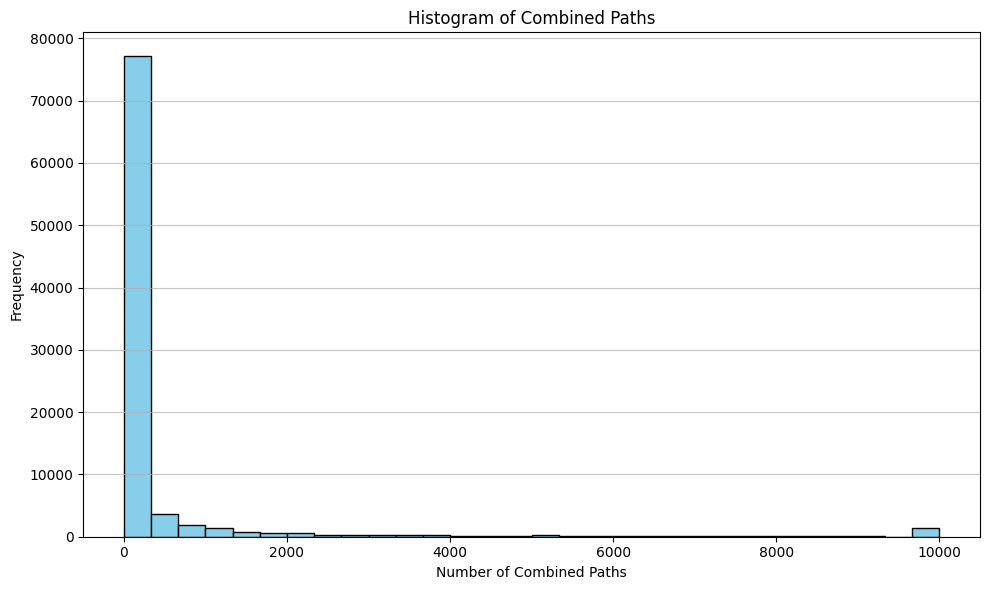

In [1]:
from glob import glob
import statistics
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.auto import tqdm
import os
import json

def parse_log_file(log_file):
    log_dict = {}
    with open(log_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        try:
            key, value = line.strip().split(": ", 1)
        except ValueError:
            continue

        if key in ["Class", "Direction"]:
            log_dict[key] = value
        elif key in [
            "Initial Upward Paths",
            "Unique Upward Paths",
            "Initial Downward Paths",
            "Unique Downward Paths",
            "Combined Paths",
            "Number of Batches",
            "Batch Size",
        ]:
            try:
                log_dict[key] = int(value)
            except ValueError:
                log_dict[key] = value
        elif key == "Time Taken":
            try:
                log_dict[key] = float(value.split()[0])
            except ValueError:
                log_dict[key] = value
        elif key == "Memory Usage":
            try:
                log_dict[key] = float(value.split()[0])
            except ValueError:
                log_dict[key] = value
        else:
            log_dict[key] = value

    return log_dict


def load_all_logs(log_directory="./extracted_paths/*/*.log"):
    log_files = glob(log_directory)
    all_class_logs = {}

    for log_file in log_files:
        log_dict = parse_log_file(log_file)
        class_name = log_dict.get("Class", f"Unknown_Class_{len(all_class_logs)+1}")
        all_class_logs[class_name] = log_dict

    return all_class_logs


def extract_paths(all_class_logs, path_type):
    """
    Extracts the specified path type from all class logs.

    Args:
        all_class_logs (dict): Parsed logs for all classes.
        path_type (str): The type of path to extract. Options: 'Unique Upward Paths', 'Combined Paths'.

    Returns:
        list[int]: A list of path counts for the specified type.
    """
    return [log[path_type] for log in all_class_logs.values() if path_type in log]


def compute_statistics(path_counts):
    stats = {}

    stats["min"] = min(path_counts)
    stats["max"] = max(path_counts)
    stats["average"] = statistics.mean(path_counts)
    stats["median"] = statistics.median(path_counts)

    try:
        stats["mode"] = statistics.mode(path_counts)
    except statistics.StatisticsError:
        stats["mode"] = statistics.multimode(path_counts)

    return stats


def plot_histogram(
    path_counts,
    bins=30,
    title="Histogram of Paths",
    xlabel="Number of Paths",
    ylabel="Frequency",
    method="matplotlib",
    save_path=None,
):
    plt.figure(figsize=(10, 6))
    if method == "seaborn":
        sns.histplot(path_counts, bins=bins, kde=False, color="skyblue")
    else:
        plt.hist(path_counts, bins=bins, color="skyblue", edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis="y", alpha=0.75)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Histogram saved to {save_path}")
    plt.show()


def main():
    # Step 1: Load all logs
    all_class_logs = load_all_logs()
    print(f"Loaded logs for {len(all_class_logs)} classes.")

    # Step 2: Extract and Analyze Path Types
    for path_type in ["Combined Paths"]:
        print(f"\nProcessing {path_type}...")

        # Extract paths
        path_counts = extract_paths(all_class_logs, path_type)
        print(f"Extracted {len(path_counts)} counts for '{path_type}'.")

        if not path_counts:
            print(f"No data found for '{path_type}'. Skipping.")
            continue

        # Compute Statistics
        statistics_dict = compute_statistics(path_counts)
        print("\nStatistical Metrics:")
        print(f"Minimum: {statistics_dict['min']}")
        print(f"Maximum: {statistics_dict['max']}")
        print(f"Average: {statistics_dict['average']:.2f}")
        print(f"Median: {statistics_dict['median']}")

        if isinstance(statistics_dict["mode"], list):
            print(f"Modes: {statistics_dict['mode']}")
        else:
            print(f"Mode: {statistics_dict['mode']}")

        # Step 3: Plot Histogram
        plot_histogram(
            path_counts,
            bins=30,
            title=f"Histogram of {path_type}",
            xlabel=f"Number of {path_type}",
            ylabel="Frequency",
            method="matplotlib",
            save_path=f'{path_type.lower().replace(" ", "_")}_histogram.png',
        )


if __name__ == "__main__":
    main()

In [2]:
for num_classes in [100, 1000, 10000, 100000]:

    # num_classes = 658
    with open("./process_p31_p279/class_counts.json", "r", encoding="utf-8") as f:
        class_counts = json.load(f)

    class_counts = {key: val for idx, (key, val) in enumerate(class_counts.items()) if idx < num_classes}


    stats = {}

    for entity_class_path in tqdm([foo for foo in glob('./extracted_paths/*') if foo.split('/')[-1] in class_counts] ):
        entity_class = entity_class_path.split('/')[-1]

        tsv_paths = glob(os.path.join(entity_class_path, "*.tsv"))
        entity_paths = []
        for tsv_path in tsv_paths:
            with open(tsv_path, "r") as f:
                for line in f:
                    path = line.strip().split("\t")
                    entity_paths.append(path)

        if len(entity_paths) == 0:
            print(f"No paths found for {entity_class}")
            continue

        stats[entity_class] = {}
        stats[entity_class]["num_paths"] = len(entity_paths)
        stats[entity_class]["path_lengths"] = [len(path) for path in entity_paths]
        stats[entity_class]["min_path_length"] = min(stats[entity_class]["path_lengths"])
        stats[entity_class]["max_path_length"] = max(stats[entity_class]["path_lengths"])
        stats[entity_class]["average_path_length"] = statistics.mean(stats[entity_class]["path_lengths"])

    # get stats for all classes
    print(f"Number of classes: {len(stats)}\n")

    print(f"total paths for {num_classes} classes: {sum([stats[entity_class]['num_paths'] for entity_class in stats])}")

    num_paths = [stats[entity_class]["num_paths"] for entity_class in stats]
    min_ = min(num_paths)
    max_ = max(num_paths)
    average_ = statistics.mean(num_paths)
    median_ = statistics.median(num_paths)
    mode_ = statistics.mode(num_paths)
    
    print(f"Min paths: {min_}")
    print(f"Max paths: {max_}")
    print(f"Average paths: {average_}")
    print(f"Median paths: {median_}")
    print(f"Mode paths: {mode_}")
    print()

    average_path_lengths = [stats[entity_class]["average_path_length"] for entity_class in stats]

    min_ = min(average_path_lengths)
    max_ = max(average_path_lengths)
    average_ = statistics.mean(average_path_lengths)
    median_ = statistics.median(average_path_lengths)
    mode_ = statistics.mode(average_path_lengths)

    print(f"Min path length: {min_}")
    print(f"Max path length: {max_}")
    print(f"Average path length: {average_}")
    print(f"Median path length: {median_}")
    print(f"Mode path length: {mode_}")
    print()


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 133.00it/s]


Number of classes: 100

total paths for 100 classes: 489540
Min paths: 3
Max paths: 10000
Average paths: 4895.4
Median paths: 3900.0
Mode paths: 10000

Min path length: 3
Max path length: 35.5
Average path length: 19.038498157887105
Median path length: 14.916086956521738
Mode path length: 9.23



100%|██████████| 1000/1000 [00:03<00:00, 285.99it/s]


Number of classes: 1000

total paths for 1000 classes: 2493188
Min paths: 1
Max paths: 10000
Average paths: 2493.188
Median paths: 531.0
Mode paths: 100

Min path length: 1
Max path length: 42.83
Average path length: 16.57128026631433
Median path length: 13.604285714285714
Mode path length: 13.97



100%|██████████| 10000/10000 [00:16<00:00, 598.47it/s]


Number of classes: 10000

total paths for 10000 classes: 11088041
Min paths: 1
Max paths: 10000
Average paths: 1108.8041
Median paths: 100.0
Mode paths: 100

Min path length: 1
Max path length: 42.83
Average path length: 15.294301495590718
Median path length: 12.950641025641026
Mode path length: 12.76



  5%|▍         | 4132/90385 [00:02<00:54, 1579.93it/s]

No paths found for Q3536385


  8%|▊         | 6903/90385 [00:04<00:58, 1416.71it/s]

No paths found for Q1394771


 15%|█▌        | 13643/90385 [00:08<00:43, 1746.75it/s]

No paths found for Q2404903


 49%|████▉     | 44506/90385 [00:31<00:43, 1047.80it/s]

No paths found for Q109535285


 85%|████████▍ | 76404/90385 [00:57<00:07, 1876.88it/s]

No paths found for Q41491


 95%|█████████▌| 86117/90385 [01:06<00:02, 1465.73it/s]

No paths found for Q6537693


 97%|█████████▋| 88093/90385 [01:07<00:01, 1442.52it/s]

No paths found for Q12761888


100%|██████████| 90385/90385 [01:09<00:00, 1303.84it/s]

Number of classes: 90378

total paths for 100000 classes: 41660714
Min paths: 1
Max paths: 10000
Average paths: 460.9607869171701
Median paths: 100.0
Mode paths: 100

Min path length: 1
Max path length: 42.83
Average path length: 13.903577489197241
Median path length: 12.425700090334237
Mode path length: 1



In [5]:
# num_classes = 658
with open("./entityid2label.json", "r", encoding="utf-8") as f:
    entityid2label = json.load(f)


In [ ]:
from glob import glob
import random

tsv_paths = glob("./extracted_paths/*/*.tsv")

[(0, 'Q35120', 'entity'),
 (1, 'Q488383', 'object'),
 (2, 'Q16686448', 'artificial object'),
 (3, 'Q1791627', 'cultural artifact'),
 (4, 'Q386724', 'work'),
 (5, 'Q8205328', 'artificial physical object'),
 (6, 'Q39546', 'physical tool'),
 (7, 'Q1183543', 'appliance'),
 (8, 'Q11019', 'machine'),
 (9, 'Q18762500', 'power engine'),
 (10, 'Q44167', 'engine'),
 (11, 'Q130760', 'turbine'),
 (12, 'Q193470', 'gas turbine'),
 (13, 'Q100251263', 'gas turbine engine'),
 (14, 'Q309027', 'turboprop'),
 (15, 'Q1352680', 'PW100'),
 (16, 'Q15624310', 'PW120')]

In [84]:
tsv_path = random.choice(tsv_paths)

tsv_data = []
with open(tsv_path, "r") as f:
    for line in f:
        tsv_data.append(line.strip().split("\t"))

path = random.choice(tsv_data)
path = [(idx, id, entityid2label[id]) for idx, id in enumerate(path)]
path

[(0, 'Q35120', 'entity'),
 (1, 'Q7048977', 'abstract entity'),
 (2, 'Q11028', 'information'),
 (3, 'Q628523', 'message'),
 (4, 'Q1151067', 'rule'),
 (5, 'Q7748', 'law'),
 (6, 'Q2386606', 'subjective right'),
 (7, 'Q332624', 'erga omnes'),
 (8, 'Q131257', 'intellectual property'),
 (9, 'Q15621286', 'intellectual work'),
 (10, 'Q17537576', 'creative work'),
 (11, 'Q17538258', 'recreative work'),
 (12, 'Q11422', 'toy'),
 (13, 'Q116037369', 'play vehicle'),
 (14, 'Q116037377', 'toy trains & train set'),
 (15, 'Q1639512', 'toy train'),
 (16, 'Q3262038', 'wooden toy train')]